In [14]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from load_and_prepare_data_functions import load_and_subsample_series, split_training_data

In [15]:
def mse_function(answer, prediction):
    mse = ((answer - prediction)**2).mean(axis=0)
    for i in range(len(answer.shape)-1):
        mse = mse.mean(axis=0)
    return mse

Data to test on

In [30]:
# Variables relating to the data you want to load
system = 'Lorentz'
x_transformation_type = 0
number_of_data_points = 10000
length_of_subsequence = 20
number_timesteps_predict = 10

In [17]:
MLonly_name = f"{system}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
MLonly_filepath = f'saved_models/{system}/timesteps_{number_timesteps_predict}/MLonly_{MLonly_name}.keras'
MLonly_model = keras.models.load_model(MLonly_filepath)

2023-08-20 15:05:36.315910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-20 15:05:36.336675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-20 15:05:36.336725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-20 15:05:36.338228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-20 15:05:36.338275: I tensorflow/compile

In [19]:
c_array = [30,40,50,60,70,80,90,100,110,120,130,140,150,175,200,225,250,275,300,400,500,600,700,800,900,1000]
c_array = [30]

name = f"{system}_{number_of_data_points}"
# train_filename = f'data_dictionaries/data_{name}.npy'
test_filename = f'data_dictionaries/data_testing_{name}.npy'
# train_data_dictionary = np.load(train_filename, allow_pickle=True).item()
test_data_dictionary = np.load(test_filename, allow_pickle=True).item()
# train_observations = train_data_dictionary["observations"]
test_observations = test_data_dictionary["observations"]

# Load the mse dictionary
mse_dictionary_savename = f"{system}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
mse_dictionary_filename = f'saved_models/{system}/timesteps_{number_timesteps_predict}/mse_dictionary_{mse_dictionary_savename}.npy'
mse_dictionary = np.load(mse_dictionary_filename , allow_pickle = True).item()

# mse_dictionary = {}
if f'x_transformation_{x_transformation_type}' not in mse_dictionary:
    mse_dictionary[f'x_transformation_{x_transformation_type}'] = {}
    mse_dictionary[f'x_transformation_{x_transformation_type}']['mse_imperfect_predictions'] = {}
    mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_loss'] = {}
    mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_error_loss'] = {}

for i, c in enumerate(c_array):
    print(str(c).replace('.', ''))
    test_predictions = test_data_dictionary[f'timesteps_{number_timesteps_predict}'][f'x_transformation_{x_transformation_type}'][c]

    # Calculate the mean squared error between the true observation and the imperfect model's prediction
    # finalmse = mse_function(test_observations[number_timesteps_predict:,:], test_predictions[:-number_timesteps_predict,:])
    # print(f"mse of imperfect predictions = {finalmse}")
    # mse_dictionary[f'x_transformation_{x_transformation_type}']['mse_imperfect_predictions'][c] = finalmse

    if c != np.inf:
        # Load the observations
        observations, predictions = load_and_subsample_series(number_of_data_points,
                                                              system,
                                                              length_of_subsequence + number_timesteps_predict,
                                                              number_timesteps_predict = number_timesteps_predict,
                                                              x_transformation_type = x_transformation_type,
                                                              c = c,
                                                              filename = test_filename)

        # Split into training and test data
        train_X, test_X, train_answer, test_answer = split_training_data(observations,
                                                                         number_timesteps_predict,
                                                                         predictions = predictions,
                                                                         frac=0)

        # Physical ML model
        save_name = f"{system}{x_transformation_type}_c{str(c).replace('.', '')}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
        # save_filepath = f'saved_models/{system}/timesteps_{number_timesteps_predict}/x_transformation_{x_transformation_type}/physical_{save_name}.keras'
        # loaded_model = keras.models.load_model(save_filepath)
        # loss_physical = loaded_model.evaluate(x = test_X, y = test_answer)
        # print(f"loss physical = {loss_physical}")
        # mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_loss'][c] = loss_physical

        # Physical error ML model
        save_filepath = f'saved_models/{system}/timesteps_{number_timesteps_predict}/x_transformation_{x_transformation_type}/physical_error_{save_name}.keras'
        loaded_model = keras.models.load_model(save_filepath)
        loss_physical_error = loaded_model.evaluate(x = test_X, y = test_answer - test_X['input_pred'])
        print(f"loss physical error = {loss_physical_error}")
        mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_error_loss'][c] = loss_physical_error
        
MLonly_loss = MLonly_model.evaluate(x = test_X['input_ob'], y = test_answer)
print(f'ML only loss = {MLonly_loss}')
mse_dictionary['MLonly_loss'] = MLonly_loss
np.save(mse_dictionary_filename, mse_dictionary)

30


2023-08-20 15:05:54.048970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904


312/312 [==============================] - 3s 4ms/step - loss: 3.3901e-05
loss physical error = 3.3900745620485395e-05
312/312 [==============================] - 2s 4ms/step - loss: 1.3954e-04
ML only loss = 0.00013954068708699197


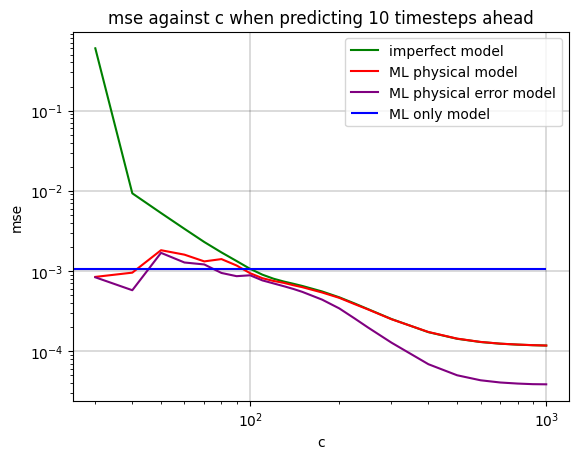

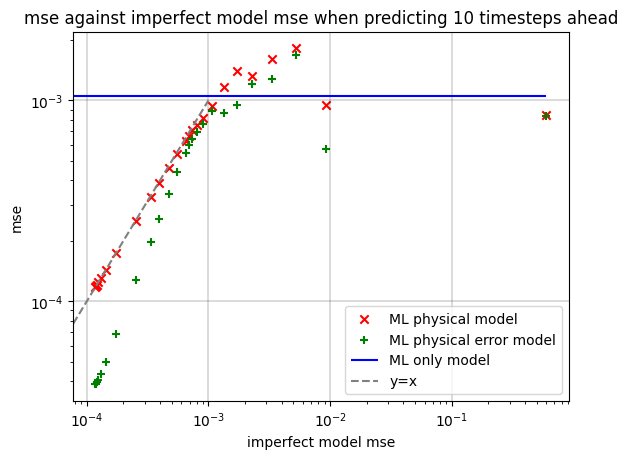

In [31]:
name = f"{system}_{number_of_data_points}"
c_array = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140 ,150, 175, 200, 225, 250, 300, 400, 500, 600, 700, 800, 900, 1000]

mse_dictionary_savename = f"{system}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
mse_dictionary_filename = f'saved_models/{system}/timesteps_{number_timesteps_predict}/mse_dictionary_{mse_dictionary_savename}.npy'
mse_dictionary = np.load(mse_dictionary_filename , allow_pickle = True).item()

finalmse = np.zeros(len(c_array))
loss_physical = np.zeros(len(c_array))
loss_physical_error = np.zeros(len(c_array))
MLonly_loss = mse_dictionary['MLonly_loss']
# mse_perfect_model_prediction = mse_dictionary[[f'x_transformation_{x_transformation_type}']]['mse_imperfect_predictions'][np.inf]

for i, c in enumerate(c_array):
    finalmse[i] = mse_dictionary[f'x_transformation_{x_transformation_type}']['mse_imperfect_predictions'][c]
    loss_physical[i] = mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_loss'][c]
    loss_physical_error[i] = mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_error_loss'][c]

plt.plot(c_array,finalmse,'-', label = 'imperfect model', color = 'g', )
plt.plot(c_array, loss_physical, '-', label = 'ML physical model', color = 'r')
plt.plot(c_array, loss_physical_error, '-', label = 'ML physical error model', color = 'purple')
plt.hlines(MLonly_loss, 0,1000, label = 'ML only model', color = 'b')
# plt.hlines(mse_perfect_model_prediction, 0,1000, linestyle = '-.', label = 'perfect model', color = 'b')
# plt.hlines(3*10**(-8), 0,1000, linestyle = '--', label = 'noise', color = 'grey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('c')
plt.ylabel('mse')
plt.grid(which='major', color='black', linestyle='-', linewidth = 0.2)
# plt.grid(which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(f'mse against c when predicting {number_timesteps_predict} timesteps ahead')
plt.savefig(f'mse_vs_c_timesteps{number_timesteps_predict}_{name}_corrected')
plt.show()

plt.scatter(finalmse, loss_physical, marker = 'x', label = 'ML physical model', color = 'r')
plt.scatter(finalmse, loss_physical_error, marker='+', label = 'ML physical error model', color = 'g')
plt.hlines(MLonly_loss, 0, np.amax(finalmse), label = 'ML only model', color = 'b')
# plt.hlines(mse_perfect_model_prediction, 0,10**(-3), linestyle = '-.', label = 'perfect model', color = 'b')
# plt.hlines(3*10**(-8), 0,1, linestyle = '-.', label = 'perfect model', color = 'b')
plt.plot([0,10**(-3)], [0,10**(-3)], '--', label = 'y=x', color = 'grey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('imperfect model mse')
plt.ylabel('mse')
plt.grid(which='major', color='black', linestyle='-', linewidth = 0.2)
# plt.grid(which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(f'mse against imperfect model mse when predicting {number_timesteps_predict} timesteps ahead')
plt.savefig(f'mse_vs_mse_timesteps{number_timesteps_predict}_{name}_corrected')
